In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta
import pickle


import warnings
warnings.filterwarnings(action='ignore') 

# 사이킷런
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# 회귀
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
pd.set_option('display.max_row', 5000)
pd.set_option('display.max_columns', 100)

from matplotlib import font_manager, rc
import matplotlib
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()

rc('font', family=font_name)

matplotlib.rcParams['axes.unicode_minus'] = False

# mission 지연변수 만들기
* 각 농가별 주차별로
* 농가 모두 합쳐서 전체 표본을 대상으로
</br>
</br>지연 시간은 5주 ~ 10주까지 돌려보자
1. 생장길이
2. 경경
3. 화방높이

In [3]:
# 생육 데이터
# 넓은들_송태근,제일_황종운 제외
sang_list =[ 
    '장수파프리카_김인기_생육']


# 환경 데이터
env_list =[
 
    '장수파프리카_김인기_환경'

]

----
# 사용자 지정함수

In [4]:
# 생육 데이터 로드
def sang_data_load(sang_farm_name,col):
    n = 'C:\\Users\\User\\OneDrive - jbnu.ac.kr\\문서\\카카오톡 받은 파일/'+sang_farm_name+'.xlsx'
    sang = pd.read_excel(n)
    sang = sang[col]
    return sang

In [5]:
# 환경 데이터 로드
def env_data_load(env_farm_name,col):
    n = 'C:\\농업기술원\\1차\\2018\\2018-2019 토마토_환경(원본)/'+env_farm_name+'.xlsx'
    #col = ['date', '내부온도', '내부습도', '지온', '지습', '이슬점', 'CO2', '외부온도', '풍속', '일사량', '누적일사량','강우', '포화수분', '절대습도', '수분부족분', '이중창환기온도', '환기온도', '난방온도']
    env = pd.read_excel(n)
    env = env[col]
    return env

In [6]:
# 일차 추가
def add_daynum(sang_df):

    sang_df['diff']=sang_df['Date'].shift(1)
    sang_df['diff2']=sang_df['Date']-sang_df['diff']
    
    num=-1
    test_week=[]
    for i in range(len(sang_df)):
        if sang_df['diff2'].loc[i]!=pd.Timedelta(0, unit='d'):
            num+=1
            test_week.append(num)
        else:
            test_week.append(num)
    del sang_df['diff']
    del sang_df['diff2']
    return test_week

In [7]:
# 12시간 짤라서 Date 추가
def env_add_Date(env_df,생육조사기간):
    df=pd.DataFrame()
    for i in range(len(생육조사기간)-1):
        start_i = 생육조사기간[i]+timedelta(hours=12)
        end_i = 생육조사기간[i+1]+timedelta(hours=12)

        df2 = env_df[(env_df['date']>=start_i) & (env_df['date']<end_i)]
        df2['Date']=생육조사기간[i+1]


        df=pd.concat([df,df2])
    return df

In [8]:
def cumsum_to_value(df):
    #누적일사량 해결
    df['lag_누적일사량']=df['누적일사량'].shift(1)
    df['일사량2']=df['누적일사량']-df['lag_누적일사량']

    #음수를 0으로 치환 NA를 0으로 치환
    df['일사량2_치환']=df['일사량2'].apply(lambda x : 0 if x<0 else x)
    df['일사량']=df['일사량2_치환'].fillna(0)

    del df['lag_누적일사량']
    del df['일사량2']
    del df['일사량2_치환']
    return df

In [9]:
# 생육 Date와 환경 Date 매칭
def match_test_weeknum(sang_data,env_data):
    dic=dict(zip(sang_data['Date'],sang_data['일차']))
    result=env_data.replace({"Date":dic})["Date"]
    return result

In [10]:
def box_to_find_outlier(env_data,name,cols):
    plt.figure(figsize=[13,8])
    plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 1, wspace = 0.5)
    cnt_cols = 2
    cnt_rows = 2 
    
    print(name[:-3:])
    for k,env in enumerate(cols):
        plt.subplot(cnt_rows, cnt_cols, k+1)

        
        sns.boxplot(data=env_data,x='일차',y=env)
        plt.title(name[:-3:]+'_'+env)
        plt.tight_layout()
    plt.show()
    print('---------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------')
        

In [11]:
def remove_outlier(df,col):
    cut_df=pd.DataFrame()
    for i in range(len(df['일차'].unique())):
        k=df[df['일차']==i+1]
        
        
        q1 = k[col].quantile(0.25)
        q3 = k[col].quantile(0.75)

        iqt = 1.5 * (q3 - q1)

        # 이상치 제거

        k=k[(k[col] < (q3 + iqt)) & (k[col] > (q1 - iqt))]
        
        cut_df=pd.concat([cut_df,k])
    return cut_df

In [12]:
def removed_outlier_pivot(df,col,aggfunc):
    cut_df=remove_outlier(df,col)
    result = cut_df.pivot_table(index='일차',
                               values=col,
                               aggfunc=aggfunc).reset_index(drop=False)

    return result

In [13]:
def pivot_lineplot(df,name,):
    plt.figure(figsize=[13,8])
    plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 1, wspace = 0.5)
    cnt_cols = 2
    cnt_rows = 2 
    
    print(name[:-3:])
    for k,env in enumerate(cols):
        plt.subplot(cnt_rows, cnt_cols, k+1)

        
        sns.boxplot(data=env_data,x='일차',y=env)
        plt.title(name[:-3:]+'_'+env)
    plt.show()
    print('---------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------')

In [14]:
total_dataset=[]
sang_dataset=[]
i=0
# 한 농장 sang 로드
sang_col=['Date', 'Sample', '생장길이']
sang_data = sang_data_load(sang_list[i],sang_col)


# 한 농장 env 로드
env_col = ['date', '내부온도', '내부습도', 'CO2', '누적일사량']
env_data = env_data_load(env_list[i],env_col)

# 한 농장에 일차 추가
sang_data['일차']=add_daynum(sang_data)
sang_dataset.append(sang_data)
# 환경에 Date컬럼 추가, 12시기준 쪼개기
생육조사기간=sorted(list(set(list(sang_data['Date']))))
env_data=env_add_Date(env_data,생육조사기간)

In [ ]:
env_data.head(500)

In [28]:
env_data['n_date']=env_data['date'].apply(lambda x : x.strftime('%Y-%m-%d'))

In [30]:
def n_date(d):
    myDatetimeStr = d
    myDatetime = datetime.strptime(myDatetimeStr, '%Y-%m-%d')
    return myDatetime

In [34]:
env_data['n_date']=env_data['n_date'].apply(n_date)

In [ ]:
env_data[['Date','n_date']].head(500)

In [ ]:
env_data['Date']-env_data['n_date']

In [80]:
def zz(d):
    result = datetime.strptime(d,'%Y-%m-%d').date()
    return result

TypeError: zz() got an unexpected keyword argument 'axis'

In [40]:
datetime(env_data['Date'][0].dt.year,env_data['Date'][0].dt.month,env_data['Date'][0].dt.date)

KeyError: 0

In [ ]:
env_data['Date'].dt.year

TypeError: cannot convert the series to <class 'int'>

장수파프리카_김인기


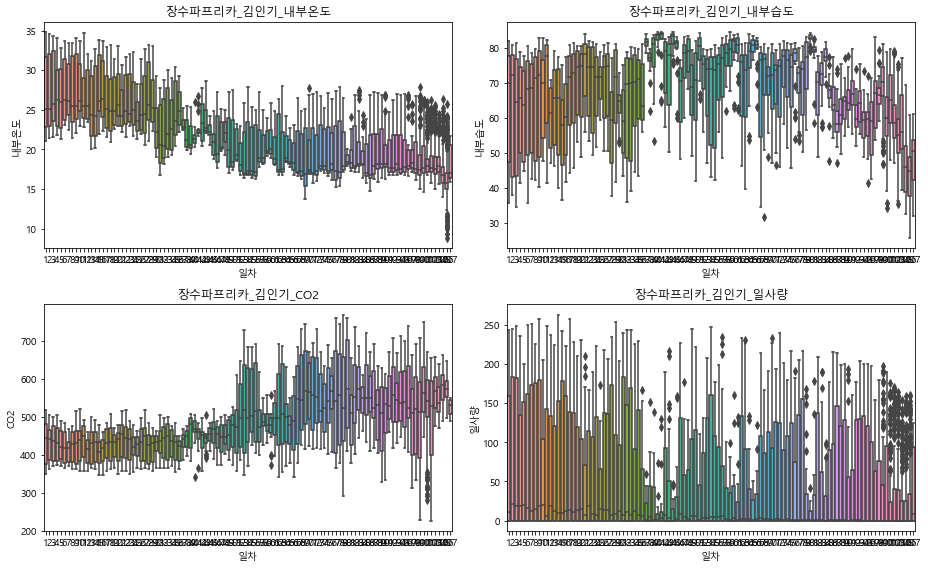

---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------


In [14]:
# 환경 데이터에 일차 컬럼 추가
env_data['일차']=match_test_weeknum(sang_data,env_data)

# 누적을 증가량으로 바꿔주기
base_col=['date','Date','일차']
cumsum_list=['누적일사량']
cumsum_col=base_col+cumsum_list

cumsum_df=cumsum_to_value(env_data[cumsum_col])
env_data['일사량']=cumsum_df['일사량']
del env_data['누적일사량']


# 환경 데이터 변수명
avg_list=['내부온도','내부습도','CO2']
sum_list=['일사량']

cols=avg_list+sum_list

# 이상치 파악하기
name=sang_list[i]
box_to_find_outlier(env_data,name,cols)
env_data=env_data.reset_index(drop=True)

total_dataset.append(env_data)

In [201]:
# 평균으로 집계할 변수와, 합으로 집계할 변수 설정하기
base_col=['Date','일차']
col='생장길이'
sang_remove_target=[col]

In [205]:
sang_dataset2 = sang_dataset[0].dropna().reset_index(drop=True)

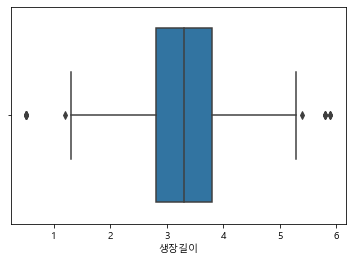

In [207]:
sns.boxplot(sang_dataset2['생장길이'])

In [210]:
q1 = sang_dataset2[col].quantile(0.25)
q3 = sang_dataset2[col].quantile(0.75)

iqt = 1.5 * (q3 - q1)

sang_dataset3=sang_dataset2[(sang_dataset2[col] < (q3 + iqt)) & (sang_dataset2[col] > (q1 - iqt))]

In [212]:
# 평균으로 집계할 변수와, 합으로 집계할 변수 설정하기
base_col=['date','Date','일차']
avg_list=['내부온도','내부습도','CO2']
sum_list=['일사량']
cols=avg_list+sum_list
aggfunc=['mean']*len(avg_list)+['sum']*len(sum_list)

In [213]:
# evn데이터 이상치 제거
pivot_set=[]
for nong in total_dataset:
    i=0
    for col,agg in zip(cols,aggfunc):
        df=nong[[col,'일차']]
        
        # 이상치 제거, 피봇
        my_pivot = removed_outlier_pivot(df,col,agg)
        
        
        if i==0:
            result = my_pivot
            i+=1
            continue
        
        result = pd.merge(result,my_pivot,how='inner',on='일차')
    pivot_set.append(result)

- 집계 데이터의 일차별 시각화

장수파프리카_김인기


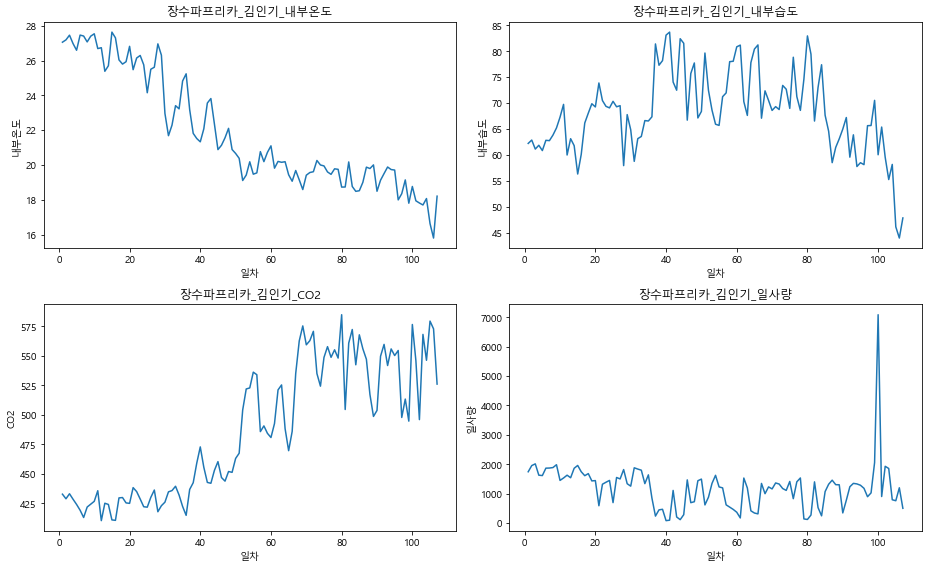

---------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------


In [214]:
for i,name in enumerate(sang_list):
    plt.figure(figsize=[13,8])
    plt.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, hspace = 1, wspace = 0.5)
    cnt_cols = 2
    cnt_rows = 2
    
    print(name[:-3:])
    df=pivot_set[i]
    for k,col in enumerate(cols):
        plt.subplot(cnt_rows, cnt_cols, k+1)
        sns.lineplot(data=df,x='일차',y=col)
        plt.title(name[:-3:]+'_'+col)
        plt.tight_layout()
    plt.show()
    print('---------------------------------------------------------------------------------------------')
    print('---------------------------------------------------------------------------------------------')
    
    

In [218]:
lag_dataset=[]

for p in pivot_set:
    lag_result=p
    for i in range(3):
        raw_col=p.columns[1:]
        later_df=p.iloc[:,1:].shift(periods=i+1)
        later_col=['_'+str(i+1)+'주전_'+j for j in list(raw_col)]
        later_df.columns=later_col

        lag_result=pd.concat([lag_result,later_df],axis=1)
    lag_dataset.append(lag_result)

In [224]:
model_dataset=[]

merge_dataset = pd.merge(sang_dataset3,lag_dataset[0],how='inner',on='일차')

model_dataset.append(merge_dataset)
del merge_dataset

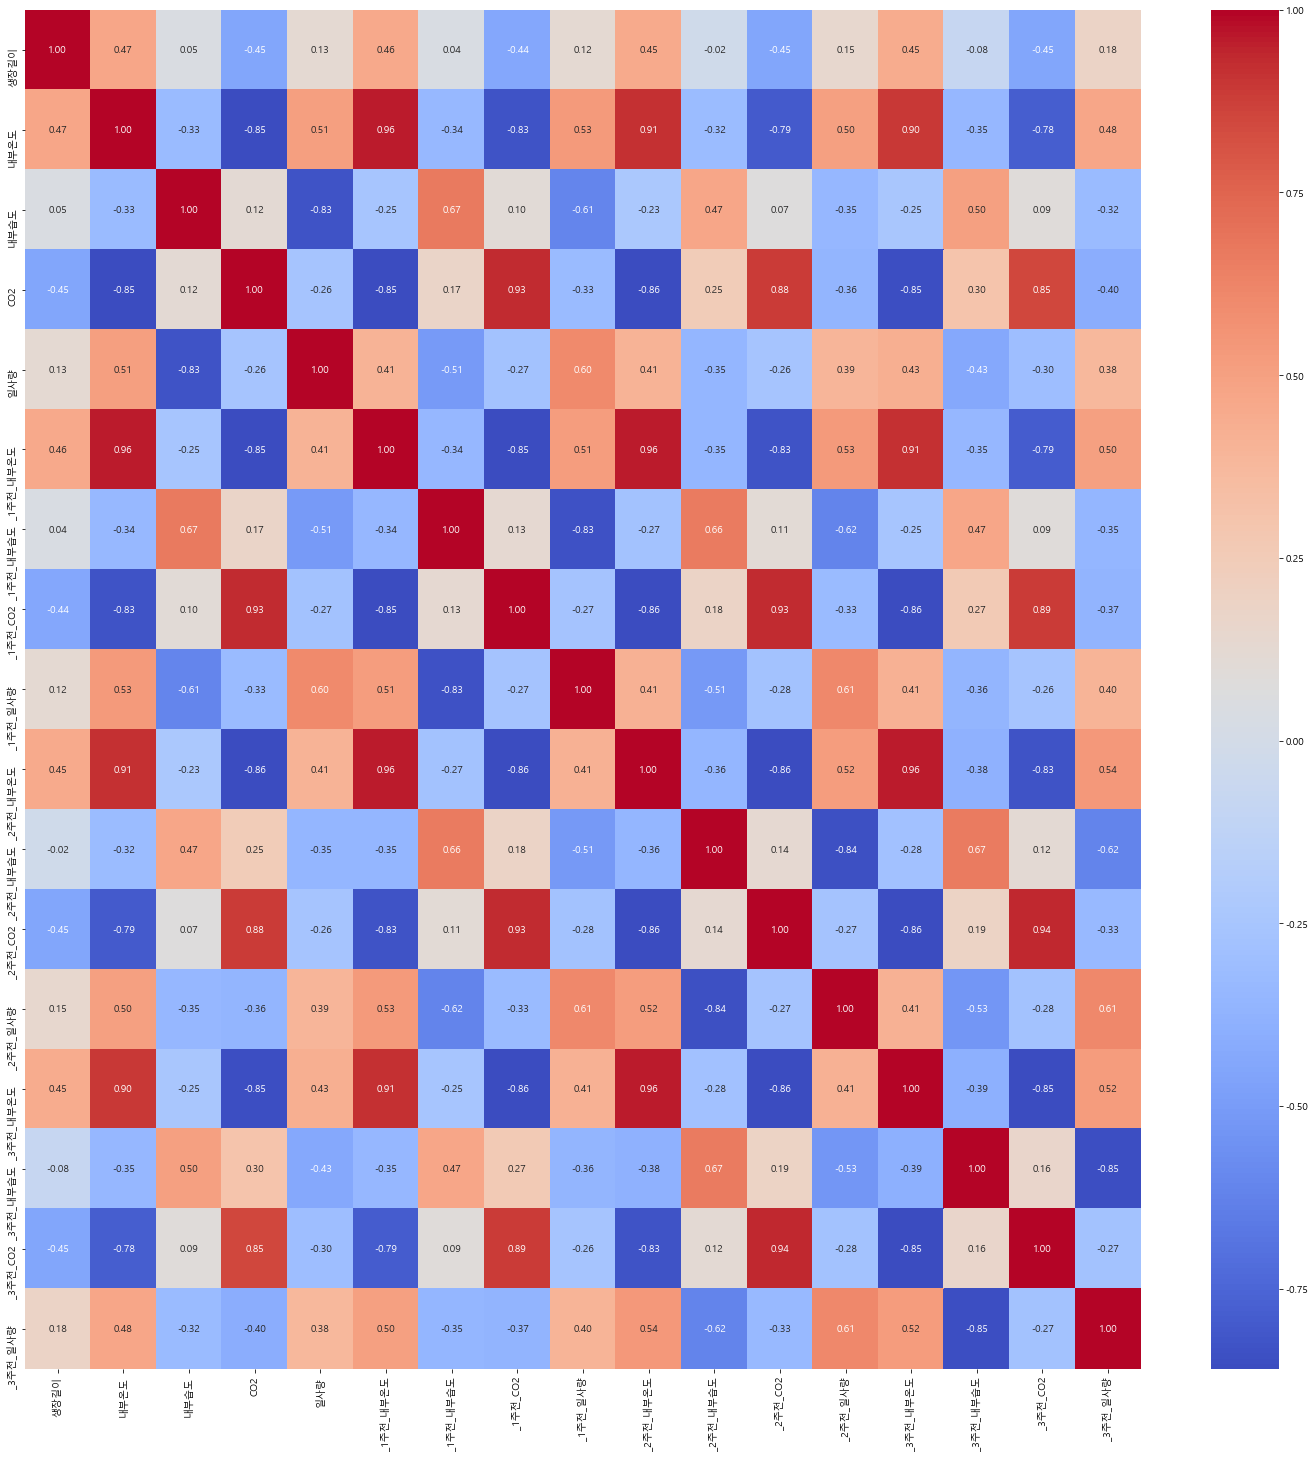

In [235]:
plt.figure(figsize=(25,25))
g = sns.heatmap(model_dataset[0].iloc[:,[2]+list(range(4,len(model_dataset[0].columns)))].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

In [227]:
from sklearn.datasets import load_boston
import xgboost
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import KFold

In [231]:
def xgb(df,Y,type=None):
    if type=='all':
        test_size=0.3
    else:
        test_size=0.25
    xgb_model = xgboost.XGBRegressor(n_estimators=100, gamma=0,
                               colsample_bytree=1, max_depth=7)

    parameters = {'subsample':[0.7,0.8,0.9],
                 'eta':[0.07,0.1,0.13],
                 'learning_rate':[0.08,0.1,0.13,0.15,0.17,0.2,0.3,0.6]}
    xgb_regressor = GridSearchCV(xgb_model,parameters,scoring='neg_mean_squared_error',cv=10)

    x_train=df.iloc[:,4:]
    y_train=df[Y]
    xgb_regressor.fit(x_train,y_train)
    print(xgb_regressor.best_params_)
    
    eta=xgb_regressor.best_params_['eta']
    learning_rate=xgb_regressor.best_params_['learning_rate']
    subsample = xgb_regressor.best_params_['subsample']
    
    # Kfold
    X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=test_size)
    xgb_model = xgboost.XGBRegressor(n_estimators=100,  gamma=0,colsample_bytree=1, max_depth=7,
                                     learning_rate=learning_rate,
                                     subsample=subsample,
                                     eta=eta
                           )

    print(len(X_train), len(X_test))
    
    xgb_model.fit(X_train,y_train)
    predictions = xgb_model.predict(X_test)
    RMSE = mean_squared_error(y_test, predictions)**0.5
    print(RMSE)
    
    
    xgboost.plot_importance(xgb_model)
    
    if type!='all':
        plt.figure(figsize=[15,7])
  #  f, ax = plt.subplots(1, 1)
    else: 
        plt.figure(figsize=[24,12])
    sns.lineplot(x=range(len(predictions)),y=predictions,label="pred")
    sns.lineplot(x=range(len(y_test)),y=y_test,label="Test")
    plt.show()
    
    print("--------------------------------------------------------------------------------------------")
    print("--------------------------------------------------------------------------------------------")
    print("--------------------------------------------------------------------------------------------")
    return RMSE

장수파프리카_김인기_
{'eta': 0.07, 'learning_rate': 0.08, 'subsample': 0.9}
413 138
0.8141182369284659


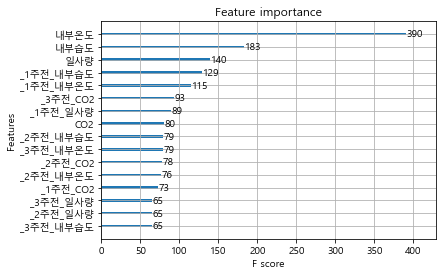

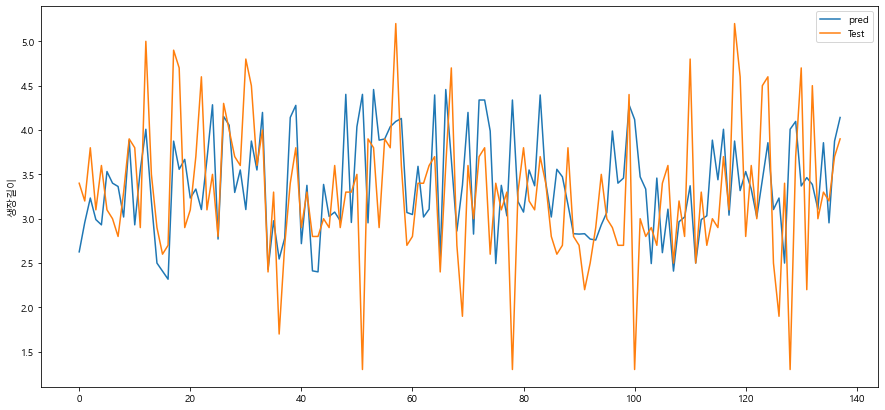

--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------


In [233]:
## 모델 Load pickle

# 농가별로 예측
Y='생장길이'
RMSE_dict = {}
for i in range(len(sang_list)):
    nong_name=sang_list[i][:-2]
    df = model_dataset[i].dropna().reset_index(drop=True)
    print(sang_list[i][:-2])
    result = xgb(df,Y)
    d={sang_list[i][:-2]:result}
    RMSE_dict.update(d)